In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.25, identitity_weight_decay=0.89)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2001/2000 | loss 2.6791 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5142 | pr auc 0.2463 | elapsed 31.58s
train epoch 01/15 | batch 2001/2000 | loss 1.6575 | val loss 0.6728 | acc 0.5483 | f1 0.3440 | prec 0.2491 | recall 0.5557 | roc auc 0.6270 | pr auc 0.4519 | elapsed 87.22s
train epoch 02/15 | batch 2001/2000 | loss 1.0005 | val loss 0.5268 | acc 0.7194 | f1 0.4824 | prec 0.3975 | recall 0.6135 | roc auc 0.7523 | pr auc 0.5827 | elapsed 87.13s
train epoch 03/15 | batch 2001/2000 | loss 0.7914 | val loss 0.4343 | acc 0.7955 | f1 0.5977 | prec 0.5146 | recall 0.7129 | roc auc 0.8378 | pr auc 0.7218 | elapsed 87.60s
train epoch 04/15 | batch 2001/2000 | loss 0.6424 | val loss 0.3679 | acc 0.8387 | f1 0.6692 | prec 0.5944 | recall 0.7657 | roc auc 0.8807 | pr auc 0.8062 | elapsed 81.35s
train epoch 05/15 | batch 2001/2000 | loss 0.5230 |

In [4]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 0003/1250 | loss 1.0740 | elapsed 0.02s

train epoch 00/10 | batch 1251/1250 | loss 1.3023 | val loss 1.3023 | acc 0.6451 | f1 0.3955 | prec 0.3140 | recall 0.5340 | roc auc 0.6464 | pr auc 0.4427 | elapsed 11.99s
train epoch 01/10 | batch 1251/1250 | loss 1.0879 | val loss 0.8414 | acc 0.7328 | f1 0.4808 | prec 0.4162 | recall 0.5692 | roc auc 0.7335 | pr auc 0.5513 | elapsed 26.22s
train epoch 02/10 | batch 1251/1250 | loss 0.7084 | val loss 0.5456 | acc 0.8074 | f1 0.5845 | prec 0.5503 | recall 0.6232 | roc auc 0.8183 | pr auc 0.6674 | elapsed 26.53s
train epoch 03/10 | batch 1251/1250 | loss 0.4726 | val loss 0.3708 | acc 0.8628 | f1 0.6849 | prec 0.6838 | recall 0.6859 | roc auc 0.8840 | pr auc 0.7751 | elapsed 26.39s
train epoch 04/10 | batch 1251/1250 | loss 0.3334 | val loss 0.2686 | acc 0.8997 | f1 0.7635 | prec 0.7834 | recall 0.7446 | roc auc 0.9265 | pr auc 0.8529 | elapsed 26.56s
train epoch 05/10 | batch 1251/1250 | loss 0.2510 | val loss 0.2076 | acc 0.9233 | f1 0.8171 | prec 0.8479 | recall 0.7884 | roc auc 0.

In [5]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240709T191713


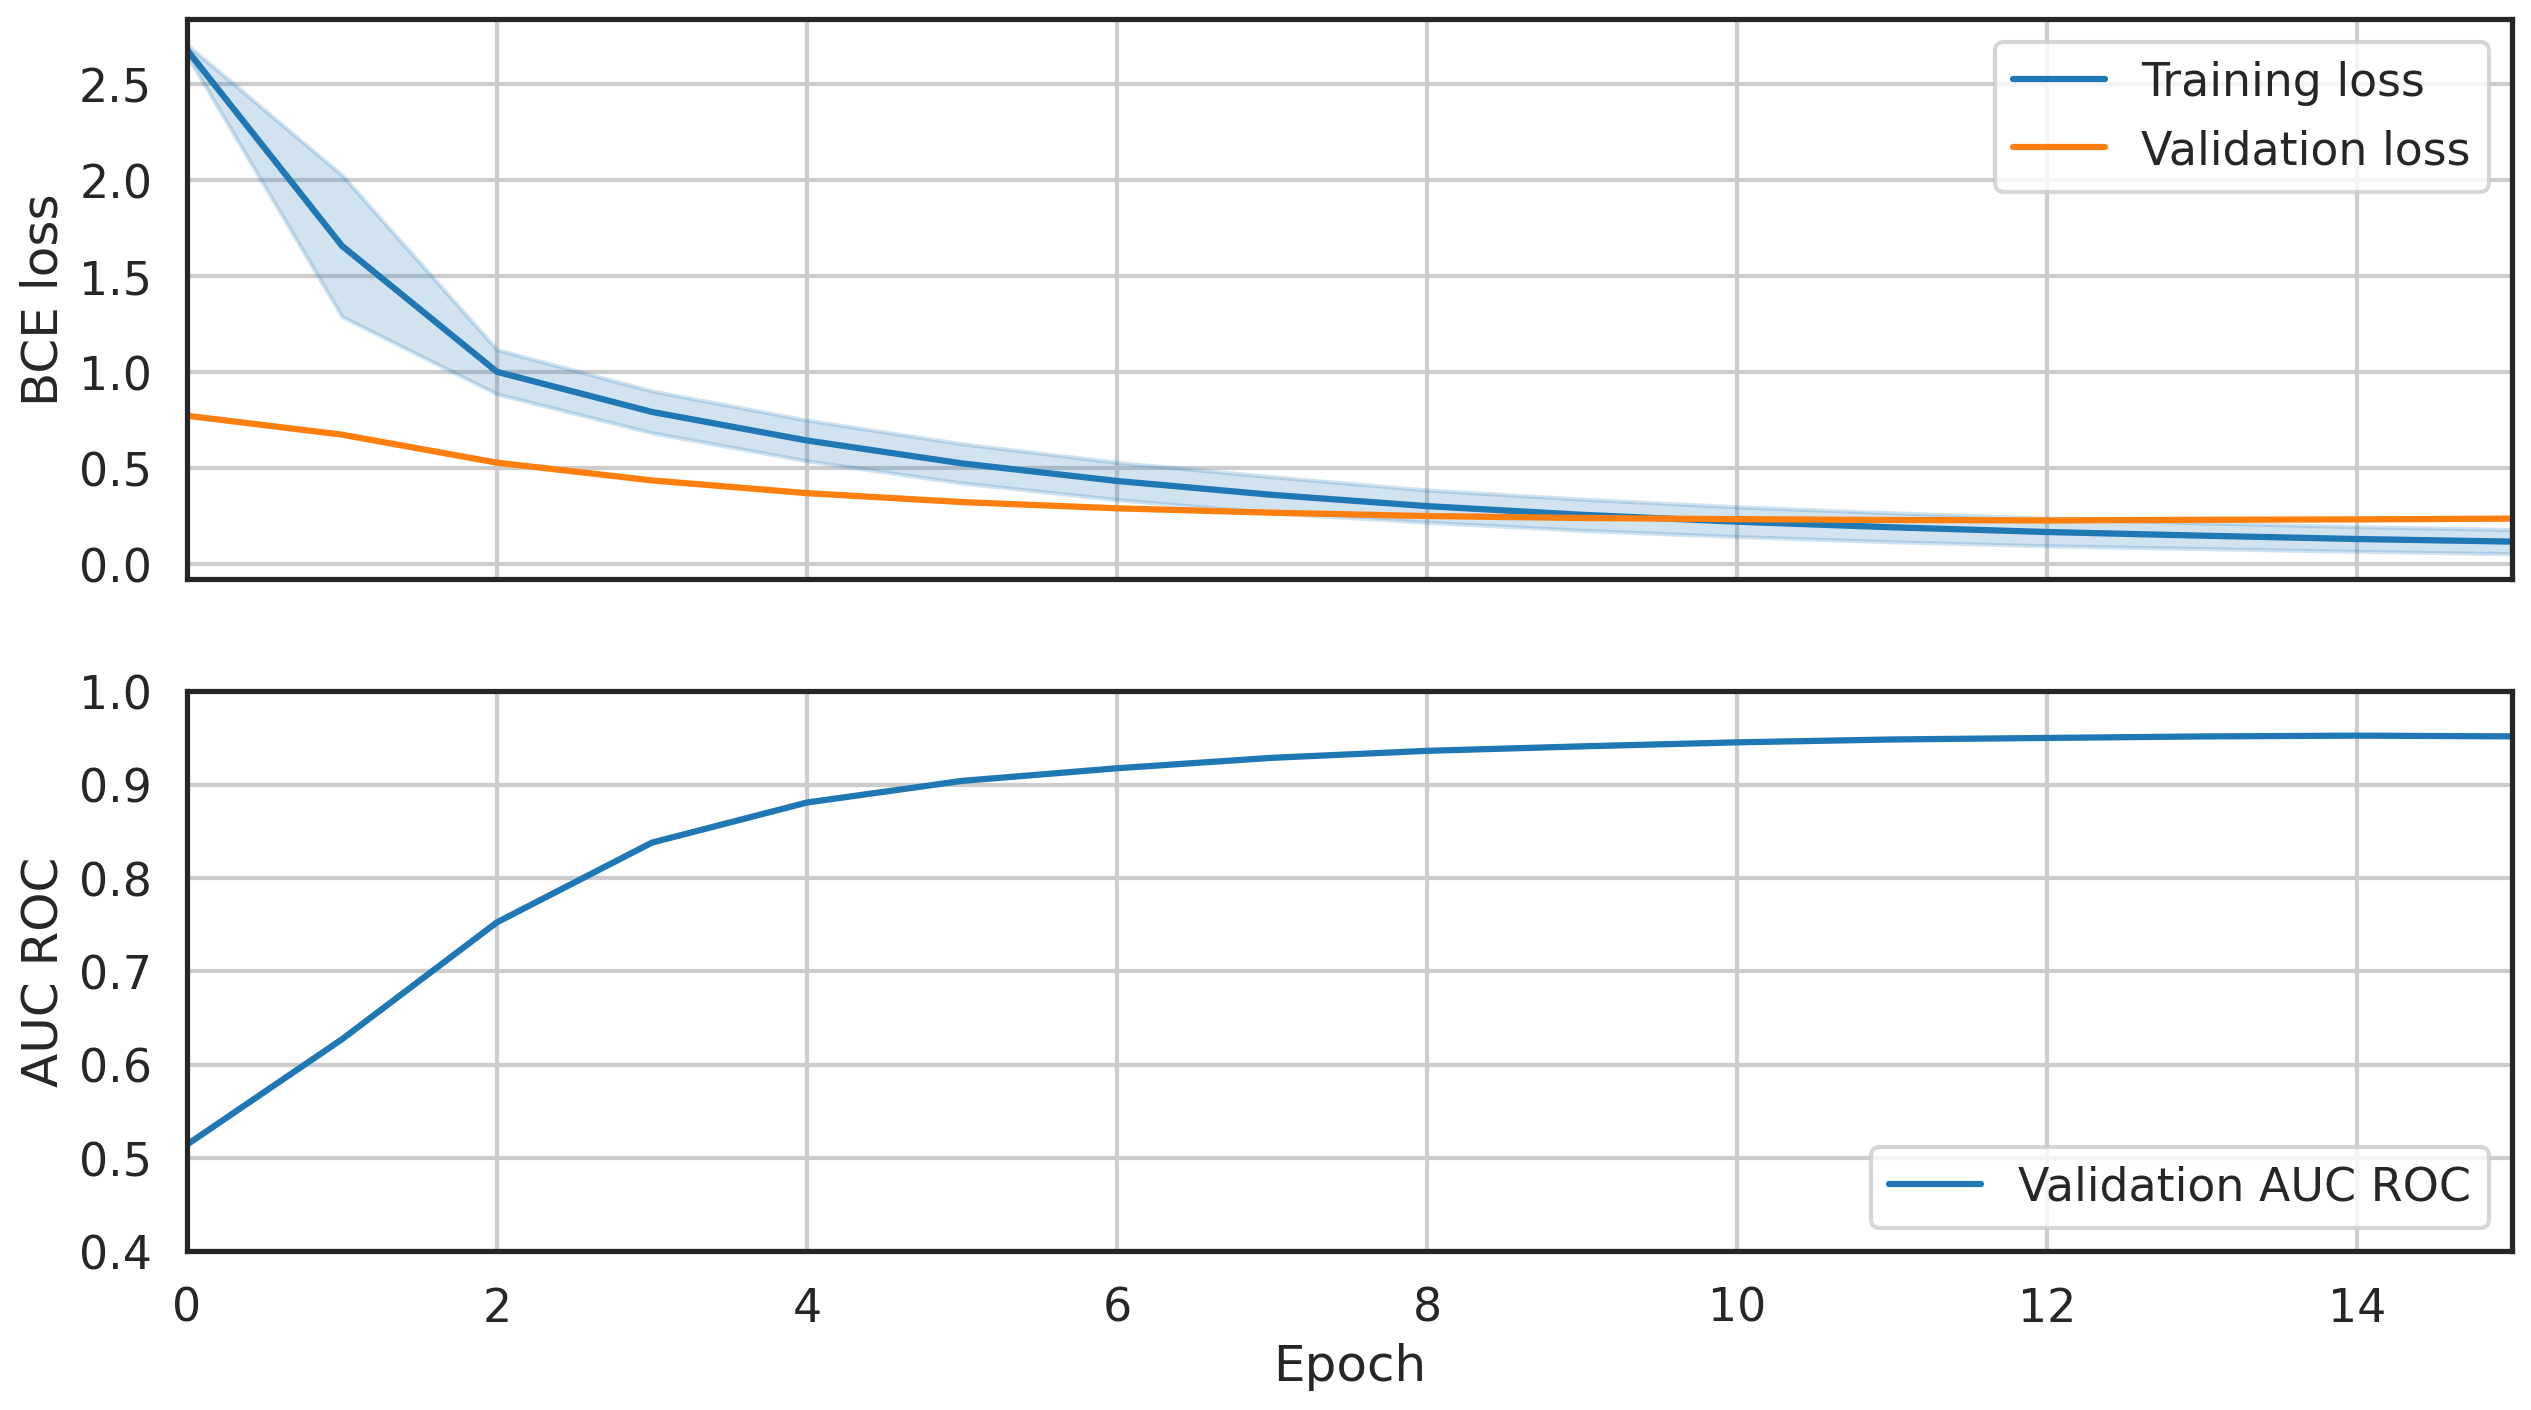

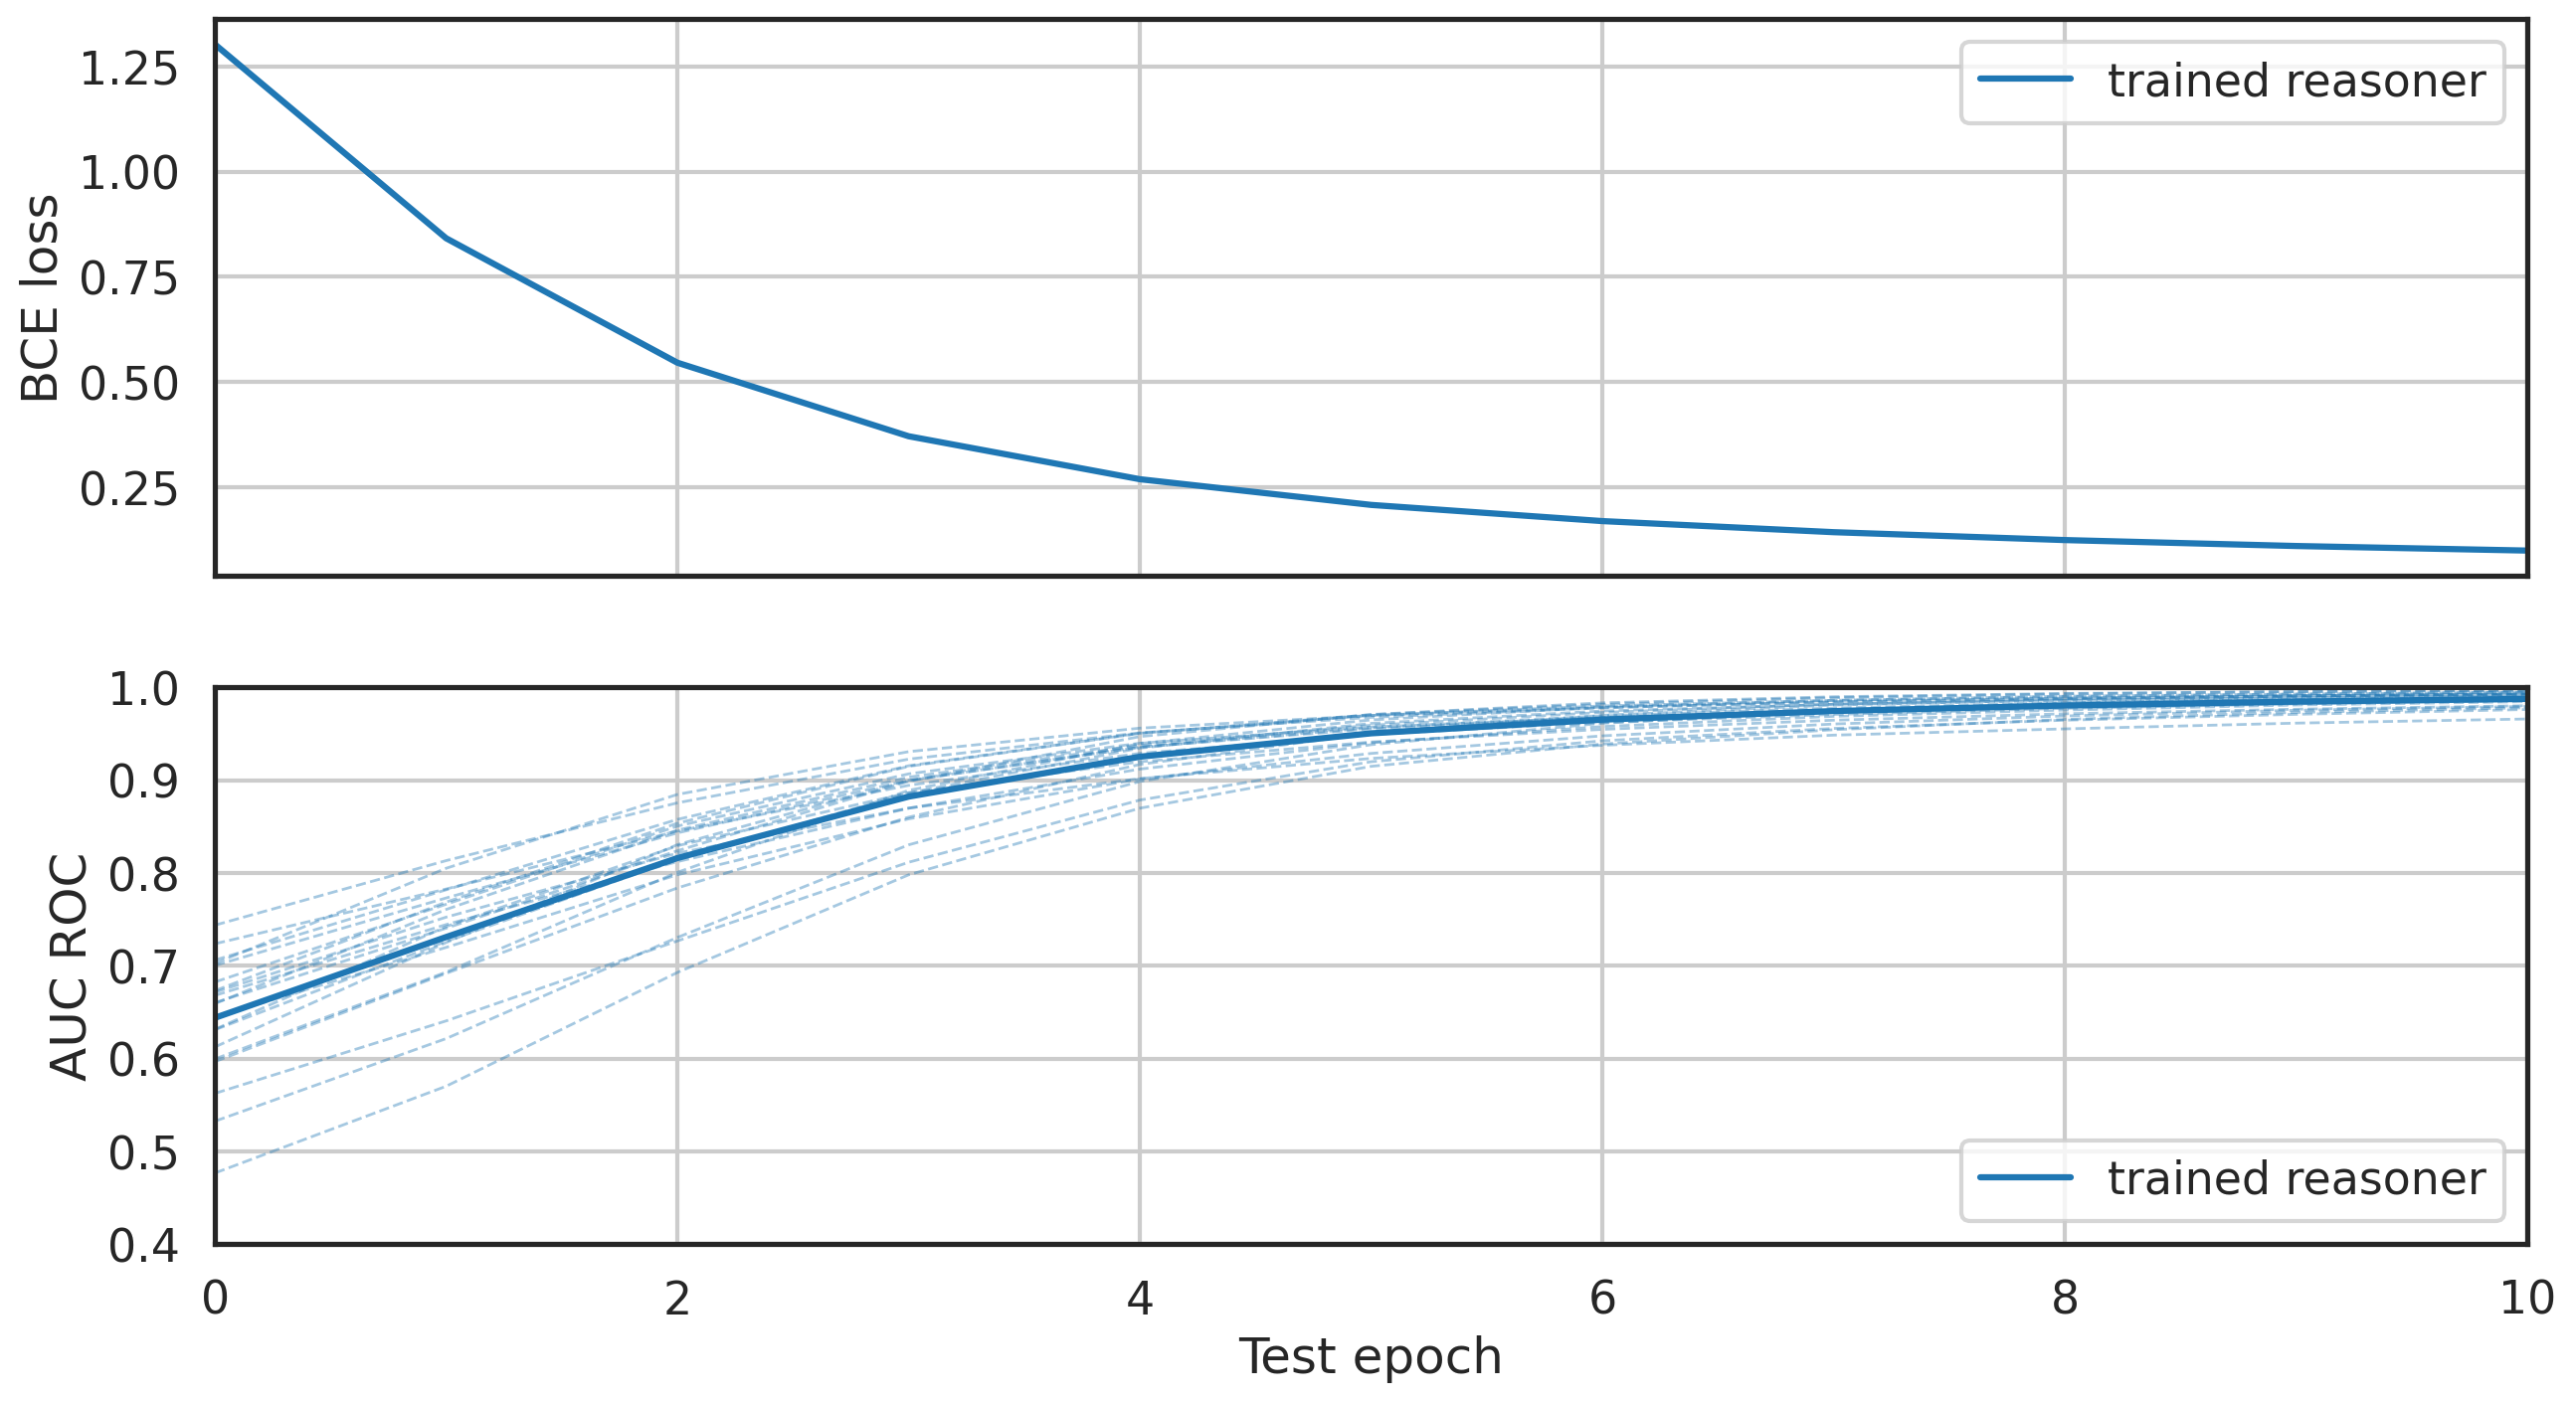

             mean       std     micro
acc      0.965250  0.015555  0.965250
prec     0.953321  0.028896  0.954014
recall   0.881693  0.045068  0.882705
f1       0.915971  0.037145  0.916975
auc_roc  0.987485  0.008096  0.988442
auc_pr   0.970875  0.017324  0.973233


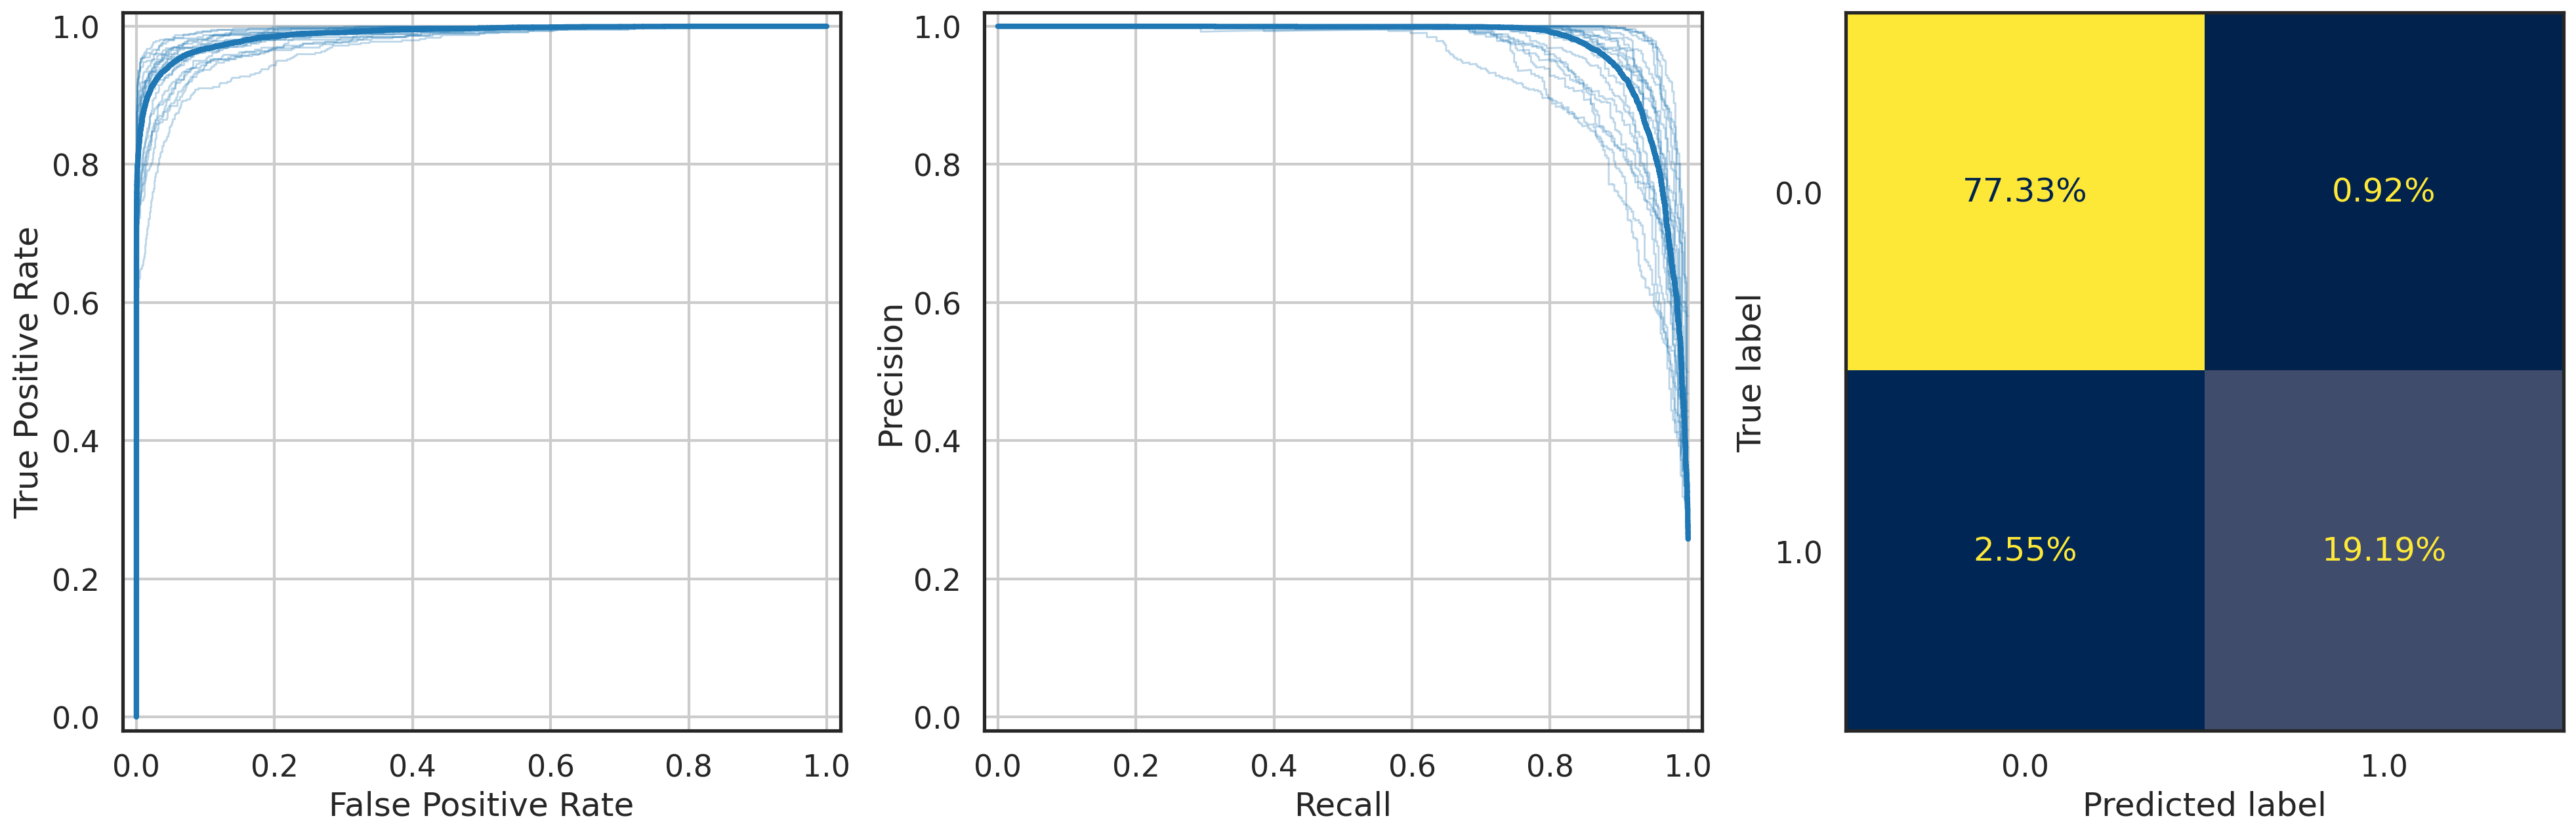

In [6]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [7]:
T.set_printoptions(precision=4)

In [34]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im_mod(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
print(np.mean(losses))

tensor([ 0.0309, -0.3197,  0.1289, -0.1713, -0.0534,  0.1920, -0.3359,  0.1905,
         0.0935,  0.0274], grad_fn=<SelectBackward0>)
tensor([ 0.0005, -0.0423, -0.0424, -0.0831,  0.0177,  0.0736, -0.1483, -0.0435,
         0.0632,  0.0200], grad_fn=<AddBackward0>)


0.10635120049118996

In [37]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.2493,  0.1416,  0.1446, -0.2332,  0.2499, -0.1078,  0.0020, -0.0340,
        -0.0690, -0.1052], grad_fn=<SelectBackward0>)
tensor([ 0.2539,  0.1381,  0.1123, -0.2305,  0.2601, -0.1192,  0.0071, -0.0015,
        -0.0587, -0.1205], grad_fn=<AddBackward0>)
0.016577273746952413


In [38]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.0890, -0.0627,  0.0071, -0.0299, -0.0061, -0.0341, -0.0799, -0.0503,
         0.1606,  0.1421], grad_fn=<SelectBackward0>)
tensor([-0.0679, -0.0902, -0.0178,  0.0316, -0.0401, -0.0152, -0.0623, -0.0700,
         0.0819,  0.0939], grad_fn=<AddBackward0>)
0.08154369182884694


In [41]:
losses = []
for _ in range(20):

    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.2493,  0.1416,  0.1446, -0.2332,  0.2499, -0.1078,  0.0020, -0.0340,
        -0.0690, -0.1052], grad_fn=<SelectBackward0>)
tensor([ 0.0752, -0.0162,  0.0165, -0.1258,  0.1037, -0.0938, -0.0811, -0.0900,
         0.0365,  0.0358], grad_fn=<AddBackward0>)
0.09768864940851926


In [42]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.2493,  0.1416,  0.1446, -0.2332,  0.2499, -0.1078,  0.0020, -0.0340,
        -0.0690, -0.1052], grad_fn=<SelectBackward0>)
tensor([ 0.2933,  0.2082,  0.2100, -0.3016,  0.3095, -0.1425, -0.0055,  0.0014,
        -0.1082, -0.1758], grad_fn=<SqueezeBackward3>)
tensor(0.0491, grad_fn=<L1LossBackward0>)


In [43]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.1524, -0.2232, -0.1147,  0.4606,  0.1054,  0.2871,  0.5581,  0.1777,
        -0.1501,  0.3167], grad_fn=<SelectBackward0>)
tensor([-0.1099, -0.1676, -0.0827,  0.3622,  0.0349,  0.2164,  0.4381,  0.1510,
        -0.0671,  0.2741], grad_fn=<SqueezeBackward3>)
tensor(0.0642, grad_fn=<L1LossBackward0>)


In [44]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.2801,  0.1391,  0.1425, -0.2290,  0.2579, -0.1351,  0.0102, -0.0012,
        -0.0767, -0.1117], grad_fn=<AddBackward0>)
tensor([ 0.2281,  0.1060,  0.0825, -0.2133,  0.2399, -0.0448,  0.0027, -0.0424,
        -0.0449, -0.0900], grad_fn=<AddBackward0>)
0.019683022564277054


In [45]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im_mod(input1, input2)), trained_reasoner.and_nn(im_mod(input2, input1))).item())

print(trained_reasoner.and_nn(im_mod(input1, input2)))
print(trained_reasoner.and_nn(im_mod(input2, input1)))

print(np.mean(losses))

tensor([ 0.0502,  0.0099,  0.0165, -0.0733,  0.0742,  0.0066, -0.0917, -0.1498,
         0.0133,  0.0246], grad_fn=<AddBackward0>)
tensor([ 0.0393,  0.0111,  0.0140, -0.1003,  0.1076,  0.0147, -0.0525, -0.1598,
         0.0399,  0.0084], grad_fn=<AddBackward0>)
0.014985236804932356


In [46]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.2173, -0.1066,  0.2707,  0.0155, -0.0975,  0.0402, -0.1218, -0.1716,
        -0.0666, -0.1041], grad_fn=<SelectBackward0>)
tensor([-0.1332, -0.0991,  0.1090,  0.0380, -0.0626,  0.0405, -0.0848, -0.1338,
         0.0049,  0.0150], grad_fn=<AddBackward0>)
0.06251865476369858


In [52]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9944353520870208


In [53]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999010562896729


In [54]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999010562896729
